In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from notebooks.backtesting_utils import get_stoch

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="MSFT"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_stoch = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

lookback = 30
smooth_k = 10
smooth_d = 10
df_stoch, df_crossovers = get_stoch(df_stoch, lookback, smooth_k, smooth_d)

In [4]:
df_stoch.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,slow_k,slow_d,position,returns,strategy
date_reference,,,,,,,,,,,
2025-10-20,MSFT,516.79,518.700,513.43,514.61,14665620,61.672327,74.080793,-1,0.006231,-0.006231
2025-10-21,MSFT,517.66,518.690,513.04,517.50,15586204,59.599095,72.539453,-1,0.001682,-0.001682
2025-10-22,MSFT,520.54,525.230,517.71,521.15,18962694,58.033242,70.442245,-1,0.005548,-0.005548
2025-10-23,MSFT,520.56,523.950,518.61,522.46,14023532,56.413426,67.840911,-1,0.000038,-0.000038
2025-10-24,MSFT,523.61,525.345,520.71,522.79,15532360,58.749894,65.558330,-1,0.005842,-0.005842


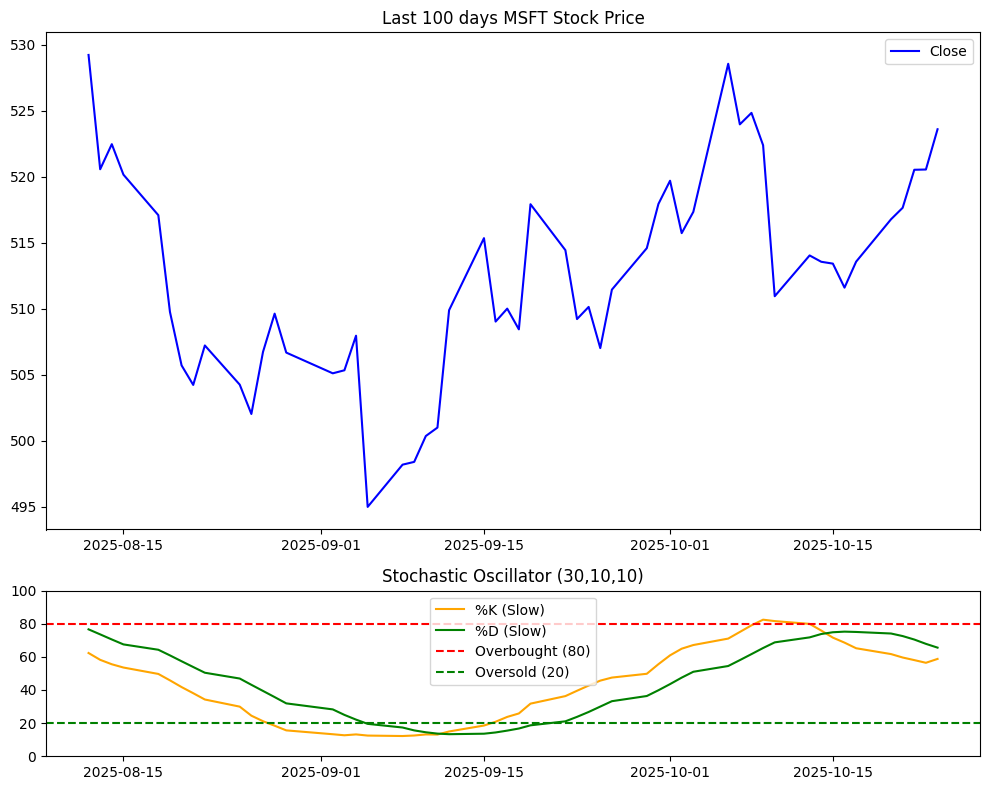

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_stoch.index, df_stoch['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: STOCH plot
axs[1].plot(df_stoch.index, df_stoch['slow_k'], label='%K (Slow)', color='orange')
axs[1].plot(df_stoch.index, df_stoch['slow_d'], label='%D (Slow)', color='green')
axs[1].axhline(80, color='red', linestyle='--', label='Overbought (80)')
axs[1].axhline(20, color='green', linestyle='--', label='Oversold (20)')
axs[1].set_title(f"Stochastic Oscillator ({lookback},{smooth_k},{smooth_d})")
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

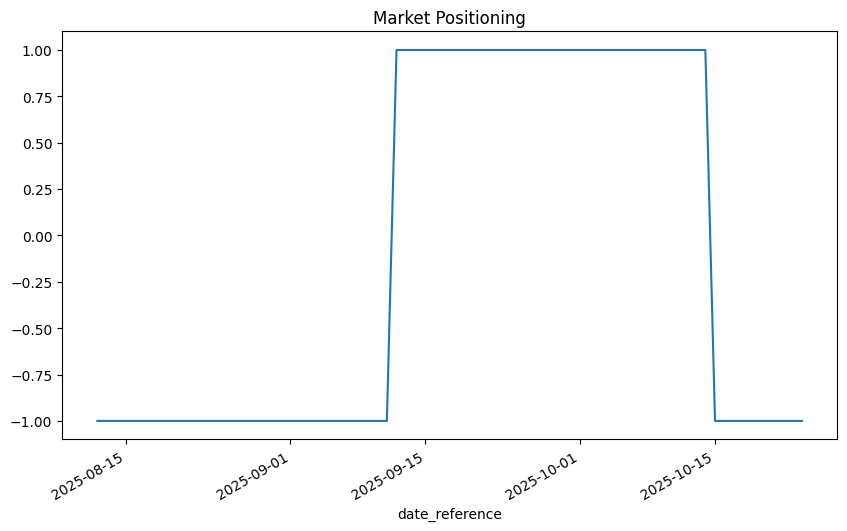

In [6]:
df_stoch['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_stoch[['returns', 'strategy']].sum().apply(np.exp)

returns     1.003526
strategy    1.010331
dtype: float64

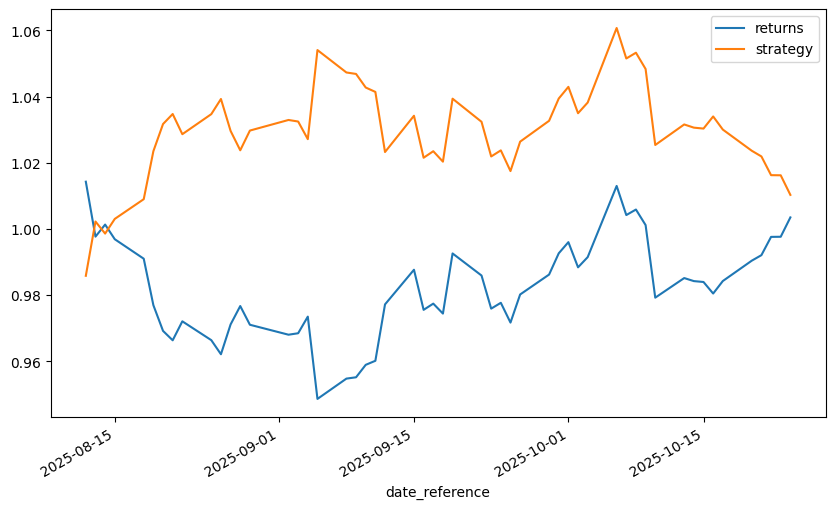

In [8]:
df_stoch[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_crossovers[['val_close', 'slow_k', 'slow_d', 'position']]

,val_close,slow_k,slow_d,position
date_reference,,,,
2025-09-12,509.90,14.970628,13.329983,1
2025-10-15,513.43,71.598131,74.843337,-1
